# Shipment Delay Prediction 

### 1. Import Libraries

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from scipy.stats import zscore

### 2. Load Data

In [2]:
# Specify the path to the zip file
zip_file_path = 'Delayed Shipments.zip'

# Open the zip file and load the CSVs into pandas DataFrames
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all the files in the zip archive
    print("Files in the zip archive:", z.namelist())
    
    with z.open('Is_delayed_prediction_Train_3_Avatar_2_Version_1_05_09_2019.csv') as train_file:
        train_df = pd.read_csv(train_file)
        
    with z.open('Is_delayed_prediction_Test_3_Avatar_2_Version_1_05_09_2019.csv') as test_file:
        test_df = pd.read_csv(test_file)

# Display the first few rows of train and test data
print("\nTraining Data (first 5 rows):")
print(train_df.head())

print("\nTesting Data (first 5 rows):")
print(test_df.head())

Files in the zip archive: ['Is_delayed_prediction_Test_3_Avatar_2_Version_1_05_09_2019.csv', 'Is_delayed_prediction_Train_3_Avatar_2_Version_1_05_09_2019.csv']

Training Data (first 5 rows):
   is_delayed  actual_TAT  SLA  is_sunday_in_between  holiday_in_between  \
0           0           1    1                     1                   0   
1           0           0    1                     1                   0   
2           0           1    1                     1                   1   
3           0           2    4                     1                   1   
4           0           1    1                     0                   0   

   pickup_lat  pickup_lon  drop_lat  drop_lon    distance  ...  \
0     28.5800     77.3300   28.6625   77.4378   13.959545  ...   
1     19.2565     72.8733   19.1309   72.8526   14.134243  ...   
2     29.7732     77.1966   28.2636   77.3990  169.009509  ...   
3     29.7732     77.1966   26.4498   74.6412  446.478107  ...   
4     26.6970     83.1

### 3. Explore the Data

Number of duplicate rows in the dataset: 220

Numerical Features: Index(['is_delayed', 'actual_TAT', 'SLA', 'is_sunday_in_between',
       'holiday_in_between', 'pickup_lat', 'pickup_lon', 'drop_lat',
       'drop_lon', 'distance',
       ...
       'pickup_time_14', 'pickup_time_15', 'pickup_time_16', 'pickup_time_17',
       'pickup_time_18', 'pickup_time_19', 'pickup_time_20', 'pickup_time_21',
       'pickup_time_22', 'pickup_time_23'],
      dtype='object', length=200)
Categorical Features: Index([], dtype='object')


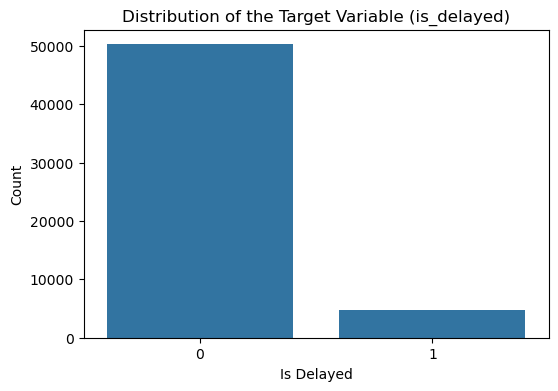

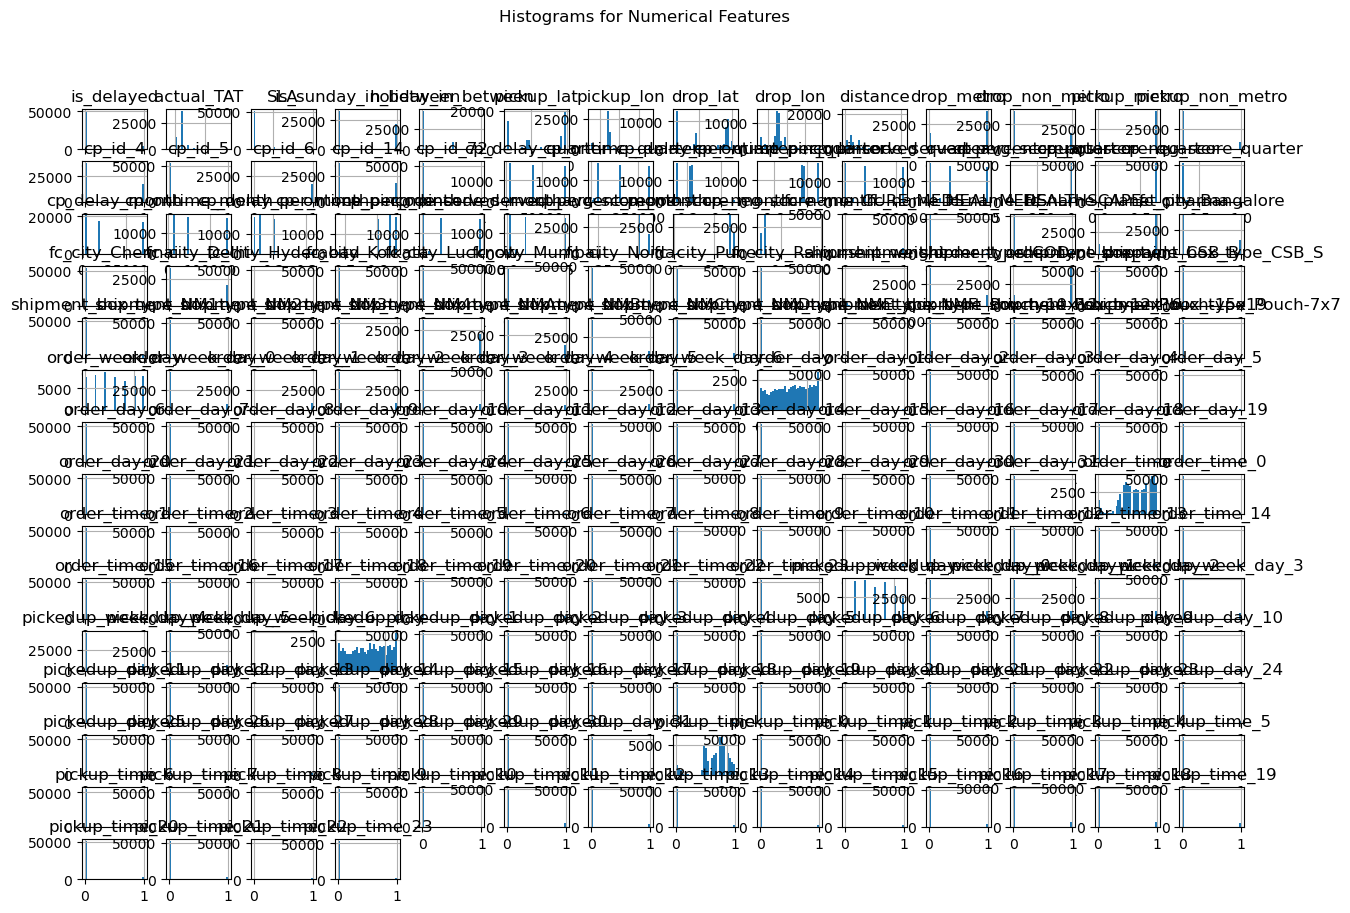

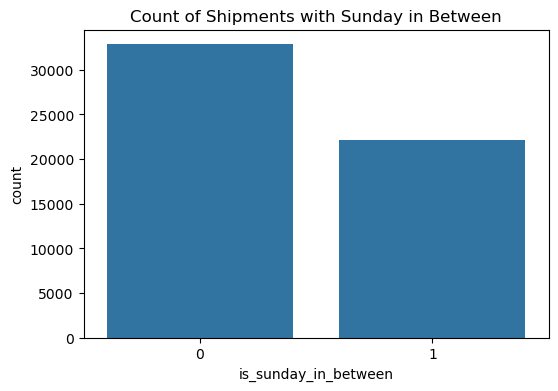

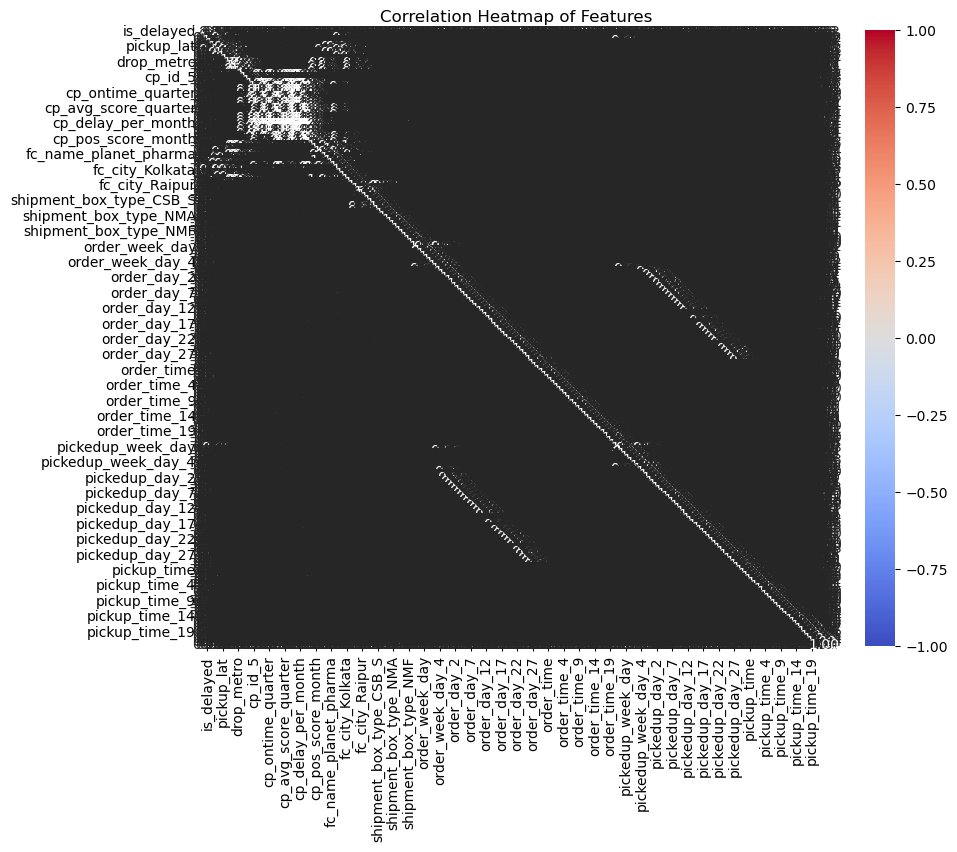

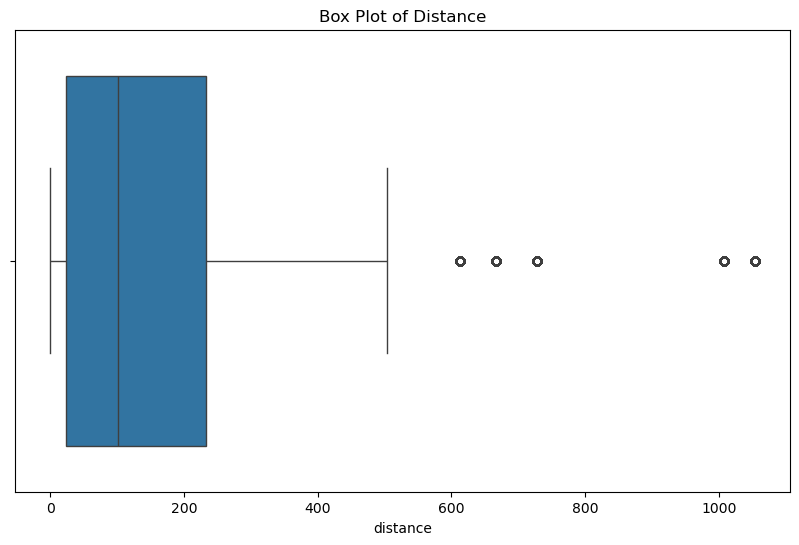

In [3]:
# Check for duplicates
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows in the dataset: {duplicates}")

# Identify numerical and categorical features
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = train_df.select_dtypes(include=['object']).columns
print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

# Examine the distribution of the target variable 'is_delayed'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_delayed', data=train_df)
plt.title('Distribution of the Target Variable (is_delayed)')
plt.xlabel('Is Delayed')
plt.ylabel('Count')
plt.show()

# Histograms for numerical features
train_df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms for Numerical Features')
plt.show()

# Bar plot for categorical features
plt.figure(figsize=(6, 4))
sns.countplot(x='is_sunday_in_between', data=train_df)
plt.title('Count of Shipments with Sunday in Between')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

# Box plots for detecting outliers in 'distance', 'SLA', and 'actual_TAT'
plt.figure(figsize=(10, 6))
sns.boxplot(x='distance', data=train_df)
plt.title('Box Plot of Distance')
plt.show()

### 4. Clean Data

In [4]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()
print(f"Number of rows after removing duplicates: {train_df.shape[0]}")

Number of rows after removing duplicates: 54757


In [5]:
# Calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    km = 6371 * c  # Earth radius in km
    return km

# Apply Haversine formula if 'distance' is not already present
if 'distance' not in train_df.columns:
    train_df['calculated_distance'] = haversine(train_df['pickup_lat'], train_df['pickup_lon'],
                                                train_df['drop_lat'], train_df['drop_lon'])
    print("Calculated distance between pickup and drop-off points.")
else:
    print("Distance column already present, skipping calculation.")

# Categorize zones (Urban/Rural) based on latitude
def categorize_zone(lat):
    return 'Urban' if lat > 25 else 'Rural'

train_df['pickup_zone'] = train_df['pickup_lat'].apply(categorize_zone)
train_df['drop_zone'] = train_df['drop_lat'].apply(categorize_zone)

# Encoding categorical features
train_df = pd.get_dummies(train_df, columns=['pickup_zone', 'drop_zone'], drop_first=True)


Distance column already present, skipping calculation.


In [6]:
# Check for boolean columns and convert them to integers
boolean_cols = train_df.select_dtypes(include=['bool']).columns
train_df[boolean_cols] = train_df[boolean_cols].astype(int)

# Define columns for numerical and categorical features
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove the target column 'is_delayed' from numerical features
numerical_cols.remove('is_delayed')

# Create imputers and scalers for numerical and categorical features
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', encoder)]), categorical_cols)
    ])

# Split data into features (X) and target (y)
X = train_df.drop('is_delayed', axis=1)
y = train_df['is_delayed']

# Apply preprocessing pipeline
X_preprocessed = preprocessor.fit_transform(X)

### 5. Train and Evaluate the Model

In [7]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Display the sizes of the resulting datasets
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (43805, 199)
Test set size: (10952, 199)



Model: LogisticRegression
Accuracy: 0.9997
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



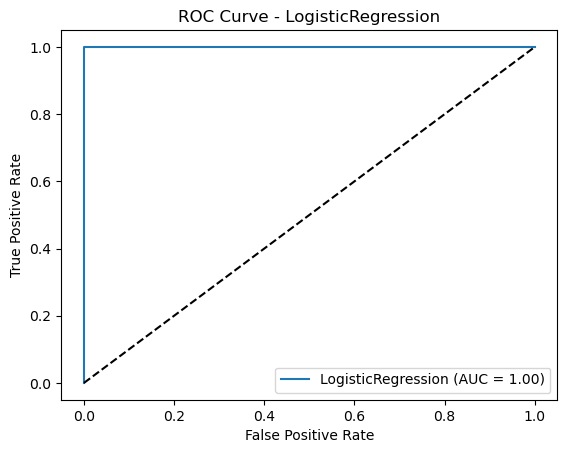


Model: DecisionTreeClassifier
Accuracy: 0.9990
AUC-ROC: 0.9956

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.99      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



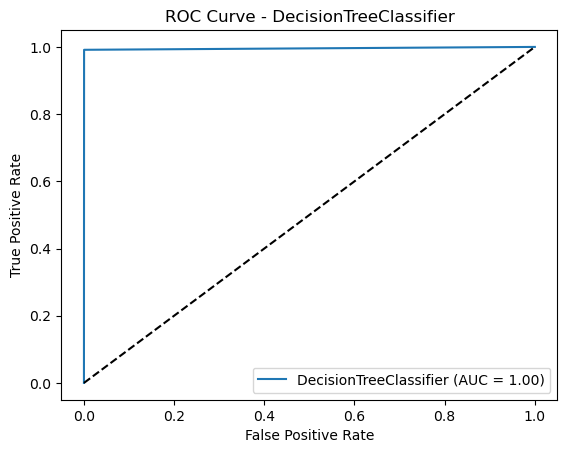


Model: RandomForestClassifier
Accuracy: 0.9980
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       0.99      0.98      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      0.99      0.99     10952
weighted avg       1.00      1.00      1.00     10952



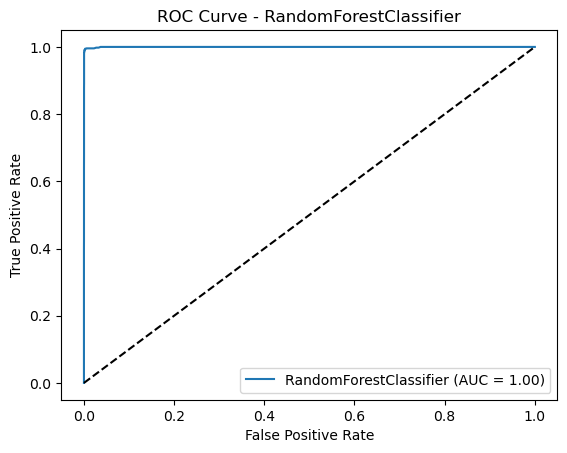

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBClassifier
Accuracy: 0.9995
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       0.99      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



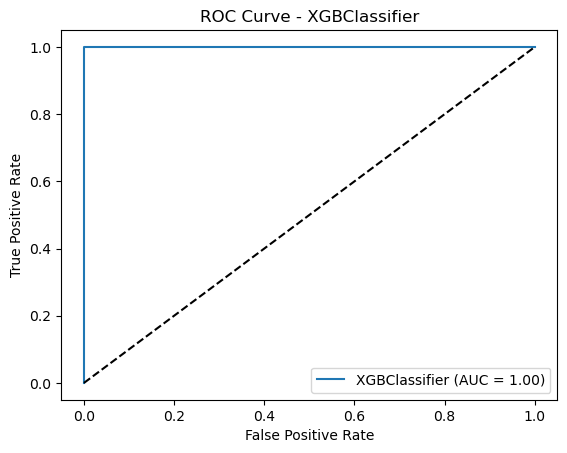

[LightGBM] [Info] Number of positive: 3748, number of negative: 40057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 43805, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085561 -> initscore=-2.369081
[LightGBM] [Info] Start training from score -2.369081

Model: LGBMClassifier
Accuracy: 0.9996
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



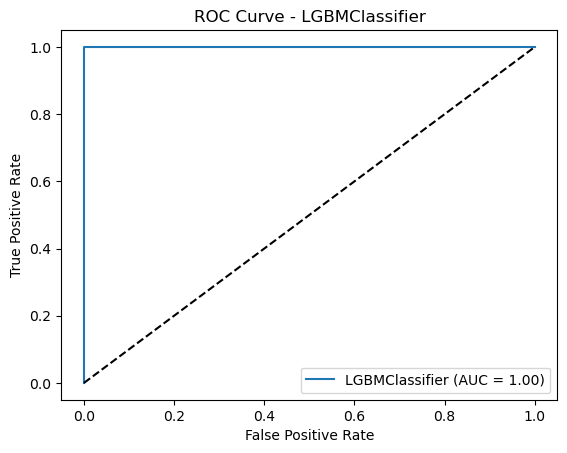


Model: SVC
Accuracy: 0.9968
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.97      0.98       934

    accuracy                           1.00     10952
   macro avg       1.00      0.98      0.99     10952
weighted avg       1.00      1.00      1.00     10952



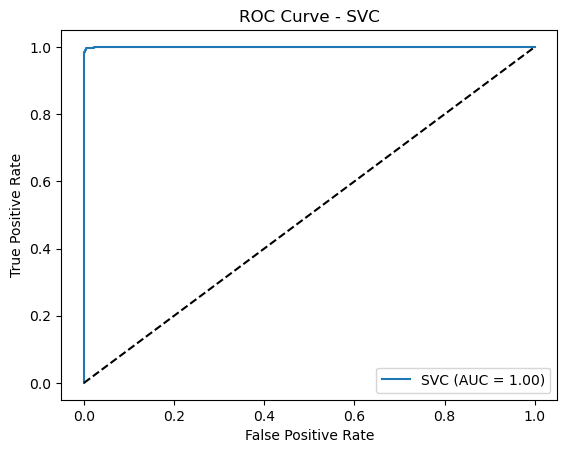

In [8]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.__class__.__name__}')
    plt.legend()
    plt.show()

# Initialize and evaluate models
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    LGBMClassifier(random_state=42),
    SVC(probability=True, random_state=42)
]

for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

### 6. Hyptertuning with GridSearchCV

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters from GridSearchCV: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Model: RandomForestClassifier
Accuracy: 0.9984
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.99      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      0.99      0.99     10952
weighted avg       1.00      1.00      1.00     10952



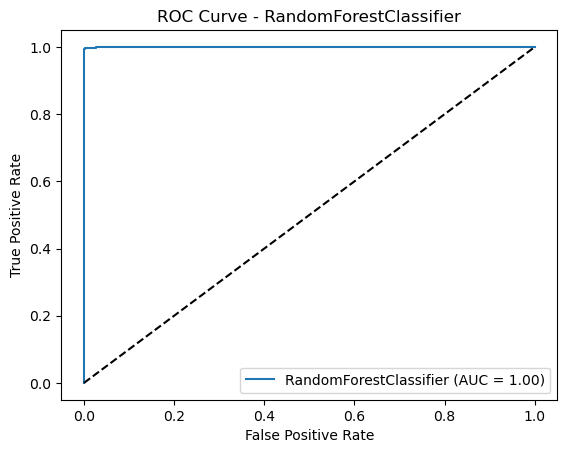

In [9]:
# Hyperparameter tuning with GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("\nBest parameters from GridSearchCV:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)